# Creating crop masks for IPAR locations

In [1]:
import pandas as pd
from pathlib import Path
import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from descartes import PolygonPatch

from matplotlib import pyplot as plt
import geojson
from shapely.geometry import Point, mapping, shape
from fiona import collection
import fiona
import geopandas as gpd
import geoplot

Contributor: Susanne Brockmann

The datasets are csv downloads of the following google sheet: https://docs.google.com/spreadsheets/d/1nvWVdWE9L2dXTytEopdFmONm23y1vAKD8bF5F6EYMrc/edit#gid=515341476

## Setting up data access

In [2]:
shape_file_folder = Path.cwd().parent.parent.joinpath('data', 'GADM', 'Senegal')
#print(shape_file_folder)
shape_file_name = "gadm36_SEN_4.shp"
shape_file_path = Path(shape_file_folder).joinpath(shape_file_name)
print(shape_file_path)

H:\Omdena-food\GPSDD-Food-Security-Senegal\data\GADM\Senegal\gadm36_SEN_4.shp


In [3]:
data_folder = Path.cwd().parent.parent.joinpath('data', )
#print(data_folder)
file_name = "yields_IPAR - rice_CSC.csv"
rice_irr_file_path = Path(data_folder).joinpath("external", "IPAR", file_name)
print(rice_irr_file_path)

H:\Omdena-food\GPSDD-Food-Security-Senegal\data\external\IPAR\yields_IPAR - rice_CSC.csv


In [9]:
rice_irr_yield = pd.read_csv(rice_irr_file_path)

In [10]:
rice_irr_yield.head()

,KEY,ID_menage,riz_irrig_csc2,riz_irrig_hiv2,crops_cult1 irrigated rice,season_cult1,Area planted (ha) irrigated rice,Quantity produced (Kg) irrigated rice,Yield (T/ha),Department,Counties,Village,gpslat,gpslon
0,uuid:05583819-bbbb-48cf-831f-90837030102a,5.580000e+38,1,0,CSC Irrigated Rice,3,0.5,700.0,1.40,MATAM,NABADJI-CIVOL,SEDDO ABBAS,15.775458,-13.468248
1,uuid:826eea2b-e840-428c-bfc0-3322b56a4354,8.270000e+39,1,1,CSC Irrigated Rice,2,5.0,30750.0,6.15,DAGANA,DIAMA,MBOUNDOUME BARRAGE,16.399498,-16.075737
2,uuid:abcf1d41-bab2-4340-a7c8-03e610962e46,1.240000e+39,1,0,CSC Irrigated Rice,2,0.4,2820.0,7.05,DAGANA,BOKHOL,BOKHOL,16.522778,-15.399270
3,uuid:ab37f2a6-51f4-41c2-9ff4-9d30d66c358e,1.240000e+39,1,0,CSC Irrigated Rice,2,1.0,4000.0,4.00,DAGANA,RONKH,H3 KEUR L ISLAM,16.341932,-16.004917
4,uuid:3513b03f-dde4-4f87-88a3-44e34125b968,3.510000e+39,1,0,CSC Irrigated Rice,2,1.0,5760.0,5.76,DAGANA,RONKH,H3 KEUR L ISLAM,16.342237,-16.004182


In [12]:
# create a geopandas dataframe and set the crs
rice_irr_yield_gpd = gpd.GeoDataFrame(rice_irr_yield, geometry=gpd.points_from_xy(rice_irr_yield.gpslon, rice_irr_yield.gpslat))
rice_irr_yield_gpd.crs ='EPSG:4326'
rice_irr_yield_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
rice_irr_yield_gpd.head()

,KEY,ID_menage,riz_irrig_csc2,riz_irrig_hiv2,crops_cult1 irrigated rice,season_cult1,Area planted (ha) irrigated rice,Quantity produced (Kg) irrigated rice,Yield (T/ha),Department,Counties,Village,gpslat,gpslon,geometry
0,uuid:05583819-bbbb-48cf-831f-90837030102a,5.580000e+38,1,0,CSC Irrigated Rice,3,0.5,700.0,1.40,MATAM,NABADJI-CIVOL,SEDDO ABBAS,15.775458,-13.468248,POINT (-13.46825 15.77546)
1,uuid:826eea2b-e840-428c-bfc0-3322b56a4354,8.270000e+39,1,1,CSC Irrigated Rice,2,5.0,30750.0,6.15,DAGANA,DIAMA,MBOUNDOUME BARRAGE,16.399498,-16.075737,POINT (-16.07574 16.39950)
2,uuid:abcf1d41-bab2-4340-a7c8-03e610962e46,1.240000e+39,1,0,CSC Irrigated Rice,2,0.4,2820.0,7.05,DAGANA,BOKHOL,BOKHOL,16.522778,-15.399270,POINT (-15.39927 16.52278)
3,uuid:ab37f2a6-51f4-41c2-9ff4-9d30d66c358e,1.240000e+39,1,0,CSC Irrigated Rice,2,1.0,4000.0,4.00,DAGANA,RONKH,H3 KEUR L ISLAM,16.341932,-16.004917,POINT (-16.00492 16.34193)
4,uuid:3513b03f-dde4-4f87-88a3-44e34125b968,3.510000e+39,1,0,CSC Irrigated Rice,2,1.0,5760.0,5.76,DAGANA,RONKH,H3 KEUR L ISLAM,16.342237,-16.004182,POINT (-16.00418 16.34224)


## Read the shapefile

In [64]:
Senegal_4 = gpd.read_file(str(shape_file_path))
Senegal_4.head()

,GID_0,NAME_0,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,geometry
0,SEN,Senegal,SEN.1_1,Dakar,SEN.1.1_1,Dakar,SEN.1.1.1_1,Almadies,SEN.1.1.1.1_1,Mermoz/ Sacre -Coeur,None,Commune,Commune,1130134,"POLYGON ((-17.46007 14.70718, -17.46102 14.706..."
1,SEN,Senegal,SEN.1_1,Dakar,SEN.1.1_1,Dakar,SEN.1.1.1_1,Almadies,SEN.1.1.1.2_1,Ngor,None,Commune,Commune,1130132,"MULTIPOLYGON (((-17.51236 14.75819, -17.51236 ..."
2,SEN,Senegal,SEN.1_1,Dakar,SEN.1.1_1,Dakar,SEN.1.1.1_1,Almadies,SEN.1.1.1.3_1,Ouakam,None,Commune,Commune,1130131,"POLYGON ((-17.48930 14.71001, -17.48930 14.710..."
3,SEN,Senegal,SEN.1_1,Dakar,SEN.1.1_1,Dakar,SEN.1.1.1_1,Almadies,SEN.1.1.1.4_1,Yoff,None,Commune,Commune,1130133,"MULTIPOLYGON (((-17.47791 14.77013, -17.47791 ..."
4,SEN,Senegal,SEN.1_1,Dakar,SEN.1.1_1,Dakar,SEN.1.1.2_1,Dakar Plateau,SEN.1.1.2.1_1,Fann/Point E/ Amitie,None,Commune,Commune,1130115,"POLYGON ((-17.45141 14.69698, -17.45139 14.696..."


## Join the two dataframes

In [76]:
rice_irr_yield_geo = gpd.sjoin(rice_irr_yield_gpd, Senegal_4, how='left', op ='within')
rice_irr_yield_geo.head()

,KEY,ID_menage,riz_irrig_csc2,riz_irrig_hiv2,crops_cult1 irrigated rice,season_cult1,Area planted (ha) irrigated rice,Quantity produced (Kg) irrigated rice,Yield (T/ha),Department,...,GID_2,NAME_2,GID_3,NAME_3,GID_4,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4
0,uuid:05583819-bbbb-48cf-831f-90837030102a,5.580000e+38,1,0,CSC Irrigated Rice,3,0.5,700.0,1.40,MATAM,...,SEN.9.2_1,Matam,SEN.9.2.2_1,Ogo,SEN.9.2.2.2_1,Nabadji Civol,None,Commune,Commune,11120202
1,uuid:826eea2b-e840-428c-bfc0-3322b56a4354,8.270000e+39,1,1,CSC Irrigated Rice,2,5.0,30750.0,6.15,DAGANA,...,SEN.10.1_1,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.1_1,Diama,None,Commune,Commune,4120201
2,uuid:abcf1d41-bab2-4340-a7c8-03e610962e46,1.240000e+39,1,0,CSC Irrigated Rice,2,0.4,2820.0,7.05,DAGANA,...,SEN.10.1_1,Dagana,SEN.10.1.1_1,Mbane,SEN.10.1.1.1_1,Bokhol,None,Commune,Commune,4120102
3,uuid:ab37f2a6-51f4-41c2-9ff4-9d30d66c358e,1.240000e+39,1,0,CSC Irrigated Rice,2,1.0,4000.0,4.00,DAGANA,...,SEN.10.1_1,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.3_1,Ronkh,None,Commune,Commune,4120203
4,uuid:3513b03f-dde4-4f87-88a3-44e34125b968,3.510000e+39,1,0,CSC Irrigated Rice,2,1.0,5760.0,5.76,DAGANA,...,SEN.10.1_1,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.3_1,Ronkh,None,Commune,Commune,4120203


In [77]:
# joining only keeps the left geometry column
rice_irr_yield_geo.columns

Index(['KEY', 'ID_menage', 'riz_irrig_csc2', 'riz_irrig_hiv2',
       'crops_cult1 irrigated rice', 'season_cult1',
       'Area planted (ha) irrigated rice',
       'Quantity produced (Kg) irrigated rice', 'Yield (T/ha)', 'Department',
       'Counties', 'Village', 'gpslat', 'gpslon', 'geometry', 'index_right',
       'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3',
       'NAME_3', 'GID_4', 'NAME_4', 'VARNAME_4', 'TYPE_4', 'ENGTYPE_4',
       'CC_4'],
      dtype='object')

In [78]:
rice_irr_yield_geo['geometry']

0      POINT (-13.46825 15.77546)
1      POINT (-16.07574 16.39950)
2      POINT (-15.39927 16.52278)
3      POINT (-16.00492 16.34193)
4      POINT (-16.00418 16.34224)
                  ...            
154               POINT (nan nan)
155    POINT (-16.10876 16.52248)
156    POINT (-15.04715 16.50343)
157    POINT (-16.07624 16.39823)
158    POINT (-16.10863 16.52243)
Name: geometry, Length: 159, dtype: geometry

In [79]:
# additional join to get the geometry column from the shapefile
rice_irr_yield_geo = pd.merge(rice_irr_yield_geo, Senegal_4[['geometry', 'CC_4']],on='CC_4', how='left')
# rename the geometry columns
rice_irr_yield_geo.rename(index=str, columns={"geometry_x": "geometry"}, inplace=True)
rice_irr_yield_geo.rename(index=str, columns={"geometry_y": "shapefile"}, inplace=True)

In [80]:
rice_irr_yield_geo.columns

Index(['KEY', 'ID_menage', 'riz_irrig_csc2', 'riz_irrig_hiv2',
       'crops_cult1 irrigated rice', 'season_cult1',
       'Area planted (ha) irrigated rice',
       'Quantity produced (Kg) irrigated rice', 'Yield (T/ha)', 'Department',
       'Counties', 'Village', 'gpslat', 'gpslon', 'geometry', 'index_right',
       'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'GID_2', 'NAME_2', 'GID_3',
       'NAME_3', 'GID_4', 'NAME_4', 'VARNAME_4', 'TYPE_4', 'ENGTYPE_4', 'CC_4',
       'shapefile'],
      dtype='object')

In [84]:
# set the shapefile column to geometry for easy access
# the geometry attribute determines which column contains the "spatial" data
rice_irr_yield_geo.set_geometry('shapefile')

,KEY,ID_menage,riz_irrig_csc2,riz_irrig_hiv2,crops_cult1 irrigated rice,season_cult1,Area planted (ha) irrigated rice,Quantity produced (Kg) irrigated rice,Yield (T/ha),Department,...,NAME_2,GID_3,NAME_3,GID_4,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,shapefile
0,uuid:05583819-bbbb-48cf-831f-90837030102a,5.580000e+38,1,0,CSC Irrigated Rice,3,0.50,700.0,1.400000,MATAM,...,Matam,SEN.9.2.2_1,Ogo,SEN.9.2.2.2_1,Nabadji Civol,None,Commune,Commune,11120202,"POLYGON ((-13.51684 15.74786, -13.51662 15.747..."
1,uuid:826eea2b-e840-428c-bfc0-3322b56a4354,8.270000e+39,1,1,CSC Irrigated Rice,2,5.00,30750.0,6.150000,DAGANA,...,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.1_1,Diama,None,Commune,Commune,4120201,"POLYGON ((-16.33625 16.39189, -16.33571 16.393..."
2,uuid:abcf1d41-bab2-4340-a7c8-03e610962e46,1.240000e+39,1,0,CSC Irrigated Rice,2,0.40,2820.0,7.050000,DAGANA,...,Dagana,SEN.10.1.1_1,Mbane,SEN.10.1.1.1_1,Bokhol,None,Commune,Commune,4120102,"POLYGON ((-15.33330 16.56324, -15.33651 16.550..."
3,uuid:ab37f2a6-51f4-41c2-9ff4-9d30d66c358e,1.240000e+39,1,0,CSC Irrigated Rice,2,1.00,4000.0,4.000000,DAGANA,...,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.3_1,Ronkh,None,Commune,Commune,4120203,"POLYGON ((-15.78633 16.35403, -15.78699 16.353..."
4,uuid:3513b03f-dde4-4f87-88a3-44e34125b968,3.510000e+39,1,0,CSC Irrigated Rice,2,1.00,5760.0,5.760000,DAGANA,...,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.3_1,Ronkh,None,Commune,Commune,4120203,"POLYGON ((-15.78633 16.35403, -15.78699 16.353..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,uuid:e784fac7-e07a-4f29-9f40-0b9b7d1b074e,5.780000e+39,1,0,CSC Irrigated Rice,1,1.00,1400.0,1.400000,MATAM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
155,uuid:b2db5d38-9240-48c1-8035-259d442669c0,2.240000e+39,1,0,CSC Irrigated Rice,2,3.46,14940.0,4.317919,DAGANA,...,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.3_1,Ronkh,None,Commune,Commune,4120203,"POLYGON ((-15.78633 16.35403, -15.78699 16.353..."
156,uuid:0be59f89-7e8c-4f90-86bc-beaf7d86f21c,2.560000e+38,1,0,CSC Irrigated Rice,2,0.57,3500.0,6.140351,PODOR,...,Podor,SEN.10.2.4_1,Thile Boubacar,SEN.10.2.4.2_1,Ndiayene Pendao,None,Commune,Commune,4220302,"POLYGON ((-15.09972 15.96580, -15.09379 16.028..."
157,uuid:4015788a-b9c1-4a9d-942b-c5797bc003e1,4.020000e+39,1,0,CSC Irrigated Rice,2,3.00,7040.0,2.346667,DAGANA,...,Dagana,SEN.10.1.2_1,Ndiaye Mberess,SEN.10.1.2.1_1,Diama,None,Commune,Commune,4120201,"POLYGON ((-16.33625 16.39189, -16.33571 16.393..."


<AxesSubplot:>

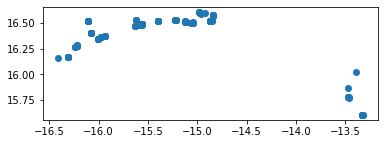

In [85]:
rice_irr_yield_geo.plot()

<AxesSubplot:>

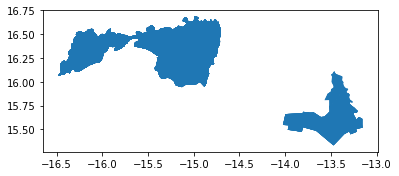

In [86]:
rice_irr_yield_geo.shapefile.plot()

In [87]:
rice_irr_yield_geo.NAME_4.unique()

array(['Nabadji Civol', 'Diama', 'Bokhol', 'Ronkh', 'Guede Village',
       'Fanaye', 'Bokidiawe', 'Ndiayene Pendao', 'Ogo', nan], dtype=object)